In [1]:
import pe_ode as pe
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp, odeint

# Test of Parameter Estimation methods for ODE model
## Model 1: Homogeneous gas phase reaction model
$$2NO+O_2\leftrightarrow2NO_2$$
is described by the following equation
$$\frac{dy}{dt}=k_1(126.2-y)(91.9-y)^2-k_2y^2;~~y(0)=0$$

In [2]:
def model1(y,k):
    dydt = k[0]*(126.2-y)*(91.9-y)**2-k[1]*y**2
    return dydt

## Model 2: Pyrolytic dehydrogenation model
Pyrolytic dehydrogenation of benzene to diphenyl and triphenyl
$$2C_2H_6\longleftrightarrow C_{12}H_{10}+H_2$$
$$C_6H_6+C_{12}H_{10}\longleftrightarrow C_{10}H_{14}+H_2$$
with differential equations model
\begin{align*}
\frac{dy_1}{dt}=&-r_1-r_2;~~y_1(0)=1\\
\frac{dy_2}{dt}=&\frac{r_1}{2}-r_2;~~~~y_2(0)=0\\
r_1=&k_1\left(y_1^2-y_2\frac{2-2y_1-y_2}{3K_1}\right)\\
r_2=&k_2\left(y_1y_2-\frac{(1-y_1-2y_2)(2-2y_1-y_2)}{9K_2}\right)
\end{align*}
with $K_1=0.242$ and $K_2=0.428$

In [3]:
def model2(y,k):
    K1 = 0.242
    K2 = 0.428
    r1 = k[0]*(y[0]**2-y[1]*(2-2*y[0]-y[1])/(3*K1))
    r2 = k[1]*(y[0]*y[1]-(1-y[0]-2*y[1])*(2-2*y[0]-y[1])/(9*K2))
    dydt = np.empty(2)
    dydt[0] = -r1-r2
    dydt[1] = r1/2-r2
    return dydt

## Jacobian
### Model 1
Differential equation $\frac{d\mathbf{J}}{dt}$ with $\mathbf{J}=\frac{\partial\mathbf{y}}{\partial\mathbf{k}}$ is
$$\frac{d\mathbf{J}}{dt}=\frac{\partial\mathbf{f}}{\partial\mathbf{y}}\mathbf{J}+\frac{\partial\mathbf{f}}{\partial\mathbf{k}}$$
For this model
$$\frac{\partial f}{\partial y}=-k_1(91.9-y)^2-2k_1(126.2-y)(91.9-y)-2k_2y$$
$$\frac{\partial f}{\partial k_1}=(126.2-y)(91.9-y)^2$$
$$\frac{\partial f}{\partial k_2}=-y^2$$

In [4]:
def model1_dfdy(y,k):
    dfdy = -k[0]*(91.9-y)**2-2*k[0]*(126.2-y)*(91.9-y)-2*k[1]*y
    return dfdy
def model1_dfdk(y,k):
    dfdk = np.empty(2)
    dfdk[0] = (126.2-y)*(91.9-y)**2
    dfdk[1] = -y**2
    return dfdk

### Model 2
\begin{align*}
r_1=&2y_1+\frac{2y_2}{3K_1}\\
r_2=&\frac{2y_1+2y_2-2}{3K_1}\\
r_3=&y_2-\frac{4y_1+5y_2-4}{9K_2}\\
r_4=&y_1-\frac{5y_1+4y_2-5}{9K_2}\\\\
\frac{\partial f_1}{\partial y_1}=&-k_1r_1-k_2r_3,\hspace{1cm}\frac{\partial f_1}{\partial y_2}=-k_1r_2-k_2r_4\\
\frac{\partial f_2}{\partial y_1}=&\frac{k_1}{2}r_1-k_2r_3,\hspace{1.3cm}\frac{\partial f_2}{\partial y_2}=\frac{k_1}{2}r_2-k_2r_4\\\\
\frac{\partial f_1}{\partial k_1}=&-\left(y_1^2+\frac{y_2^2+2y_1y_2-2y_2}{3K_1}\right)\\
\frac{\partial f_1}{\partial k_2}=&-\left(y_1y_2-\frac{2y_1^2-4y_1+5y_1y_2-5y_2+2y_2^2+2}{9K_2}\right)\\
\frac{\partial f_2}{\partial k_1}=&-\frac{1}{2}\frac{\partial f_1}{\partial k_1}\\
\frac{\partial f_2}{\partial k_2}=&\frac{\partial f_1}{\partial k_2}
\end{align*}

In [5]:
def model2_dfdy(y,k):
    K1 = 0.242
    K2 = 0.428
    r1 = 2*y[0]+2*y[1]/(3*K1)
    r2 = 2*(y[0]+y[1]-1)/(3*K1)
    r3 = y[1]-(4*y[0]+5*y[1]-4)/(9*K2)
    r4 = y[0]-(5*y[0]+4*y[1]-5)/(9*K2)
    dfdy = np.empty((2,2))
    dfdy[0,0] = -k[0]*r1-k[1]*r3
    dfdy[0,1] = -k[0]*r2-k[1]*r4
    dfdy[1,0] = k[0]*r1/2-k[1]*r3
    dfdy[1,1] = k[0]*r2/2-k[1]*r4
    return dfdy
def model2_dfdk(y,k):
    K1 = 0.242
    K2 = 0.428
    dfdk = np.empty((2,2))
    dfdk[0,0] = -(y[0]**2+(y[1]**2+2*y[0]*y[1]-2*y[1])/(3*K1))
    dfdk[0,1] = -(y[0]*y[1]-(2*y[0]**2-4*y[0]+5*y[0]*y[1]-5*y[1]+2*y[1]**2+2)/(9*K2))
    dfdk[1,0] = -dfdk[0,0]/2
    dfdk[1,1] = dfdk[0,1]
    return dfdk

## Comparison with numerical differentiation
Numerical differentiation by `pe_ode` functions and analytic results given above will be compared. 
### Model 1
Homogeneous gas model has 15 measurements and the parameter estimations are $k_1=0.4577\times10^{-5}$ and $k_2=0.2796\times10^{-3}$

In [6]:
yhat_model1=np.array([[0,1.4,6.3,10.5,14.2,17.6,21.4,23.0,27.0,30.5,34.4,38.8,41.6,43.5,45.3]])
t_model1 = np.array([0,1,2,3,4,5,6,7,9,11,14,19,24,29,39])
k_model1 = np.array([0.4577e-5,0.2796e-3])

In [7]:
dfdy_anal = np.empty(15)
dfdy_num = np.empty(15)
dfdk_anal = np.empty((2,15))
dfdk_num = np.empty((2,15))
y_temp = pe.state_only_int(model1,np.array([0]),k_model1,t_model1)
y_k_model1 = y_temp[0]
for i in range(15):
    dfdy_anal[i] = model1_dfdy(y_k_model1[:,i],k_model1)
    dfdy_num[i] = pe.dfdy_ode(model1,y_k_model1[:,i],k_model1,1)
    dfdk_anal[:,i] = model1_dfdk(y_k_model1[:,i],k_model1)
    dfdk_num[:,i] = pe.dfdk_ode(model1,y_k_model1[:,i],k_model1,1,2)
dfdy_diff = dfdy_anal-dfdy_num
dfdk_diff = dfdk_anal-dfdk_num
rel_dfdy = np.max(np.abs(dfdy_diff))/np.linalg.norm(dfdy_anal,np.inf)
rel_dfdk = np.max(np.abs(dfdk_diff))/np.linalg.norm(dfdk_anal,np.inf)
print('dfdy difference {0:1.2e} (inf norm)'.format(rel_dfdy))    
print('dfdk difference {0:1.2e} (inf norm)'.format(rel_dfdk))

dfdy difference 7.08e-07 (inf norm)
dfdk difference 7.64e-15 (inf norm)


### Model 2
Dehydrogenation model has eight measurements and the parameter estimations are $k_1=354.61$ and $k_2=400.23$

In [8]:
t_model2 = np.array([0,5.63,11.32,16.97,22.62,34.00,39.70,45.20,169.7],dtype='f')*1e-4
yhat_model2 = np.array([[1,0.828,0.704,0.622,0.565,0.499,0.482,0.470,0.443],
                   [0,0.0737,0.1130,0.1322,0.1400,0.1468,0.1477,0.1477,0.1476]],dtype='f')
y0_model2 = yhat_model2[:,0]
k_model2 = np.array([354.61,400.23])

In [9]:
k1000 = np.array([1000,1000],dtype='float64')
N_model2 = np.size(t_model2)
dfdy_model2_ana = np.empty((N_model2,2,2))
dfdy_model2_num = np.empty((N_model2,2,2))
dfdk_model2_ana = np.empty((N_model2,2,2))
dfdk_model2_num = np.empty((N_model2,2,2))
y1000,fasu = pe.state_only_int(model2,y0_model2,k1000,t_model2)
for i in range(N_model2):
    dfdy_model2_ana[i] = model2_dfdy(y1000[:,i],k1000)
    dfdy_model2_num[i] = pe.dfdy_ode(model2,y1000[:,i],k1000,2)
    dfdk_model2_ana[i] = model2_dfdk(y1000[:,i],k1000)
    dfdk_model2_num[i] = pe.dfdk_ode(model2,y1000[:,i],k1000,2,2)
dfdy_diff = dfdy_model2_ana-dfdy_model2_num
dfdk_diff = dfdk_model2_ana-dfdk_model2_num
rel_dfdy = np.linalg.norm(dfdy_diff)/np.linalg.norm(dfdy_model2_ana)
rel_dfdk = np.linalg.norm(dfdk_diff)/np.linalg.norm(dfdk_model2_ana)
print('dfdy difference {0:1.2e}'.format(rel_dfdy))
print('dfdk difference {0:1.2e}'.format(rel_dfdk))

dfdy difference 2.69e-09
dfdk difference 2.87e-06


## Test of $\varphi(\mathbf{z})$
### Model 1
With an artificial initial condition $y_0=10$, $\mathbf{J}=\begin{bmatrix}1000&2000\end{bmatrix}$
$$\frac{dy}{dt}=4.577\times10^{-6}(126.2-10)(91.9-10)^2-2.796\times10^{-4}\times10^2=3.5395$$
$$\frac{\partial f}{\partial y}=-4.577\times10^{-6}(91.9-10)^2-2\times4.577\times10^{-6}(126.2-10)(91.9-10)-2\times2.796\times10^{-4}\times10=-0.1234$$
$$\frac{\partial f}{\partial k_1}=(126.2-10)(91.9-10)^2=779424$$
$$\frac{\partial f}{\partial k_2}=-10^2=-100$$
The differential equation for Jacobian is
$$\frac{d\mathbf{J}}{dt}=-0.1234\times\begin{bmatrix}1000 & 2000\end{bmatrix}+\begin{bmatrix}779424&-100\end{bmatrix}=\begin{bmatrix}779301&-346.8\end{bmatrix}$$

In [10]:
y_temp = 10
dfdy_model1_ana = model1_dfdy(y_temp,k_model1)
dfdk_model1_ana = model1_dfdk(10,k_model1)
J_temp = np.array([1000,2000])
dJdt_model1_ana = dfdy_model1_ana*J_temp+dfdk_model1_ana
print('Analytic dJdt is ',dJdt_model1_ana)
z = np.empty(3)
z[0] = y_temp
z[1:] = J_temp
dJdt_model1_num = pe.phi_z(model1,z,k_model1,1,2)
print('Numerical dJdt is ',dJdt_model1_num[1:])

Analytic dJdt is  [ 7.79300873e+05 -3.46818670e+02]
Numerical dJdt is  [ 7.79300873e+05 -3.46818788e+02]


### Model 2
Artificial initial condition $y0=[5~~10]$ and $\mathbf{J}=\begin{bmatrix}
200&300\\
150&50\end{bmatrix}$
$$\frac{d\mathbf{J}}{dt}=\frac{\partial\mathbf{f}}{\partial\mathbf{y}}\mathbf{J}+\frac{\partial\mathbf{f}}{\partial\mathbf{k}}$$

In [11]:
y_model2_temp0 = np.array([5,10])
J_model2_temp = np.array([[200,300],[150,50]])
dfdy_model2_temp = model2_dfdy(y_model2_temp0,k_model2)
dfdk_model2_temp = model2_dfdk(y_model2_temp0,k_model2)
dJdt_model2_ana = np.matmul(dfdy_model2_temp,J_model2_temp)+dfdk_model2_temp
z_model2 = np.empty(6)
z_model2[0:2] = y_model2_temp0
z_model2[2:] = J_model2_temp.transpose().flatten()
dzdt_model2 = pe.phi_z(model2,z_model2,k_model2,2,2)
dJdt_model2_num = dzdt_model2[2:].reshape(2,2).transpose()
print('Analytic dJdt is \n',dJdt_model2_ana)
print('Numerical dJdt is \n',dJdt_model2_num)

Analytic dJdt is 
 [[-3508740.85315775 -3610034.82730877]
 [ 3563353.91956953  3407433.3131871 ]]
Numerical dJdt is 
 [[-3508741.33291654 -3610035.15135963]
 [ 3563354.37318194  3407433.77309991]]


## Integration with estimated parameters
### Model 1

In [12]:
y0 = yhat_model1[:,0]
res_model1 = pe.state_jacob_int(model1,y0,k_model1,t_model1)

Jacobian
[[0. 0.]]
[[ 9.27370654e+05 -6.89875129e+00]]
[[ 1.63014749e+06 -4.84419743e+01]]
[[ 2.16757281e+06 -1.44611048e+02]]
[[ 2.58077504e+06 -3.05211321e+02]]
[[ 2.89900622e+06 -5.33798827e+02]]
[[ 3.14403358e+06 -8.30288775e+02]]
[[ 3.33115141e+06 -1.19188702e+03]]
[[ 3.57842540e+06 -2.09397023e+03]]
[[ 3.70681368e+06 -3.20044231e+03]]
[[3763593.48611649   -5150.32635678]]
[[3669696.49666203   -8853.71520985]]
[[3482142.95125699  -12718.05799824]]
[[3274617.8936603   -16431.03234524]]
[[2905273.18131808  -22776.51257757]]
True


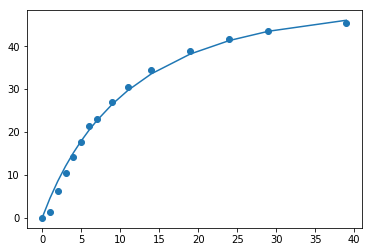

In [35]:
plt.clf()
plt.figure(1)
plt.scatter(t_model1,yhat_model1)
plt.plot(t_model1,res_model1[0][0,:])
print('Jacobian')
print(*res_model1[1],sep='\n')
print(res_model1[2])

### Model 2

Jacobian
[[0. 0.]
 [0. 0.]]
[[-3.90267081e-04 -1.62685326e-05]
 [ 1.69437807e-04 -1.93878548e-05]]
[[-5.26574250e-04 -3.82839771e-05]
 [ 2.08403141e-04 -5.19365181e-05]]
[[-5.25552588e-04 -5.14564067e-05]
 [ 1.97280549e-04 -7.60591874e-05]]
[[-4.65126820e-04 -5.58872386e-05]
 [ 1.70508583e-04 -8.72084943e-05]]
[[-3.07581678e-04 -4.93449214e-05]
 [ 1.13525940e-04 -8.08521169e-05]]
[[-2.38931834e-04 -4.27692119e-05]
 [ 8.98380206e-05 -7.06632214e-05]]
[[-1.84061115e-04 -3.60878218e-05]
 [ 7.07467410e-05 -5.98401691e-05]]
[[-1.30737774e-07 -5.85794893e-08]
 [ 7.75995370e-08 -1.26581694e-07]]
True


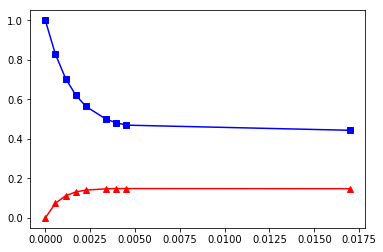

In [45]:
res_model2 = pe.state_jacob_int(model2,y0_model2,k_model2,t_model2)
plt.figure(2)
plt.plot(t_model2,yhat_model2[0,:],'bs',t_model2,yhat_model2[1,:],'r^')
plt.plot(t_model2,res_model2[0][0,:],'b',t_model2,res_model2[0][1,:],'r')
print('Jacobian')
print(*res_model2[1],sep='\n')
print(res_model2[2])

## Calculation of objective function and gradient of the objective function
### Model 1 

In [46]:
Q1 = np.eye(1)
S, g = pe.Sg_ode(model1,yhat_model1,Q1,k_model1,t_model1)
print(S)
print(g)

21.866257353210703
[-7.73248480e+03  5.97742677e+00]


### Model 2

In [47]:
Q2 = np.eye(2)
S2, g2 = pe.Sg_ode(model2,yhat_model2,Q2,k_model2,t_model2)
print(S2)
print(g2)

7.105348481987903e-06
[5.80758976e-09 2.45733185e-09]
